In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [12]:
# Load data
X = np.load("data/XCM/wmz/X.npy")  # Shape: (1350, 1000, 8)
y = np.load("data/XCM/happiness_labels.npy")
# y = np.load("data/XCM/excitement_labels.npy")

# Step 1: Split into train and test sets (10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Step 2: Feature extraction using FFT
def extract_fft_features(X, start=0, n_freq=20):
    """
    Extract FFT amplitude features from each channel and segment.
    Returns shape: (num_samples, n_freq * num_channels)
    """
    N = X.shape[1]
    fft_vals = np.fft.rfft(X, axis=1)  # Real FFT along time axis
    fft_mag = np.abs(fft_vals)[:, start:start + n_freq, :]  # Take magnitude, truncate to first n_freq
    return fft_mag.reshape(X.shape[0], -1)

# Extract features
start = 230 # h:230 e:195
X_train_fft = extract_fft_features(X_train, start)
X_test_fft = extract_fft_features(X_test, start)

# Step 3: Linear regression
model = LinearRegression()
model.fit(X_train_fft, y_train)

# Step 4: Predict and evaluate
y_pred = model.predict(X_test_fft)
mse = mean_squared_error(y_test, y_pred)

print("Test MSE:", mse)


Test MSE: 7.704941935756465


In [9]:
# Shuffle y to create a random prediction
y_shuffled = y.copy()
np.random.shuffle(y_shuffled)

# Take the first len(y_test) values as prediction
y_pred_shuffled = y_shuffled[:len(y_test)]

# Evaluate
mse_shuffled = mean_squared_error(y_test, y_pred_shuffled)
print("Shuffled prediction MSE:", mse_shuffled)

Shuffled prediction MSE: 17.514814814814816


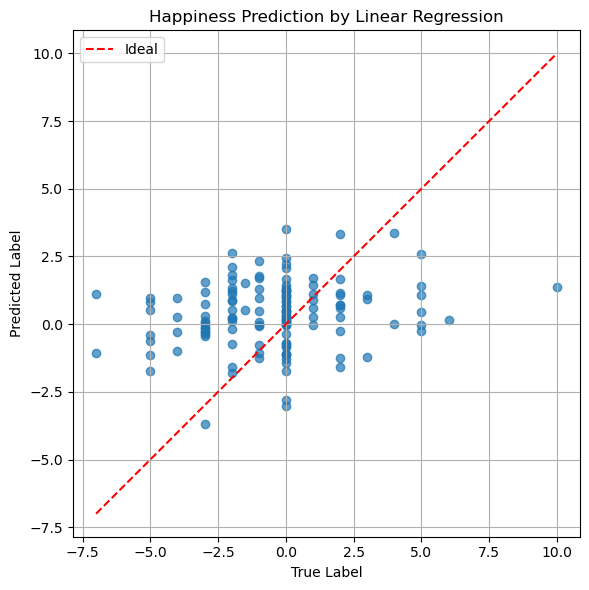

Test MSE: 7.7049
Pearson Correlation Coefficient (PCC): 0.1968
Shuffled prediction MSE: 17.5148


In [10]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')  # y = x 线
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
# plt.title("Excitement Prediction by Linear Regression")
plt.title("Happiness Prediction by Linear Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(f"Test MSE: {mse:.4f}")
pcc, p_value = pearsonr(y_test, y_pred)
print(f"Pearson Correlation Coefficient (PCC): {pcc:.4f}")
print(f"Shuffled prediction MSE: {mse_shuffled:.4f}")

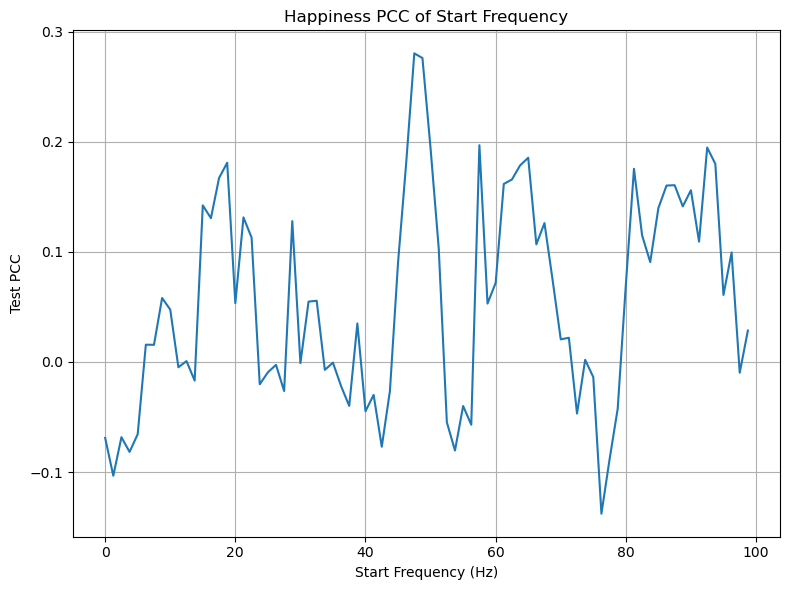

In [5]:
start_values = list(range(0, 400, 5))
pcc_list = []

for start in start_values:
    X_train_fft = extract_fft_features(X_train, start=start, n_freq=20)
    X_test_fft = extract_fft_features(X_test, start=start, n_freq=20)

    model = LinearRegression()
    model.fit(X_train_fft, y_train)
    y_pred = model.predict(X_test_fft)

    pcc, _ = pearsonr(y_test, y_pred)
    pcc_list.append(pcc)

# 每个 start 对应的频率（以Hz为单位）
sampling_rate = 250
N = 1000
freqs = [start * sampling_rate / N for start in start_values]

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(freqs, pcc_list)
plt.xlabel("Start Frequency (Hz)")
plt.ylabel("Test PCC")
plt.title("Happiness PCC of Start Frequency")
# plt.title("Excitement PCC of Start Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()